In [194]:
from scipy.optimize import linprog
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [195]:
#Trip prediction data for 1/31/2019
path = "~/Documents/Berkeley MEng/Spring Semester/290/Project/datax_bikeshare/data/trips_final_20190131.csv"
data = pd.read_csv(path)
data.head()

,Unnamed: 0,start_date,start_hour,start_station_id,start_station_name,start_station_cap,start_station_has_kiosk,end_station_id,end_station_name,end_station_cap,...,wind,precip_,start_dow_Friday,start_dow_Monday,start_dow_Saturday,start_dow_Sunday,start_dow_Thursday,start_dow_Tuesday,start_dow_Wednesday,trip_count_predicted
0,118630,2019-01-31,0,116,Mississippi St at 17th St,31.0,True,93,4th St at Mission Bay Blvd S,27.0,...,6.0,0.0,0,0,0,0,1,0,0,1.094604
1,118631,2019-01-31,0,285,Webster St at O'Farrell St,27.0,True,61,Howard St at 8th St,27.0,...,6.0,0.0,0,0,0,0,1,0,0,1.079082
2,118632,2019-01-31,1,380,Masonic Ave at Turk St,23.0,True,52,McAllister St at Baker St,27.0,...,5.0,0.0,0,0,0,0,1,0,0,1.085881
3,118633,2019-01-31,2,78,Folsom St at 9th St,27.0,True,321,5th St at Folsom,31.0,...,5.0,0.0,0,0,0,0,1,0,0,1.078276
4,118634,2019-01-31,3,36,Folsom St at 3rd St,31.0,True,14,Clay St at Battery St,31.0,...,0.0,0.0,0,0,0,0,1,0,0,1.008814


In [196]:
bikes_out = data.groupby(['start_station_id'])['trip_count_predicted'].sum()   #Total bikes predicted to leave each station on this day
bikes_in = data.groupby(['end_station_id'])['trip_count_predicted'].sum()      #Total bikes predicted to enter each station on this day
df = pd.concat([bikes_out, bikes_in], axis=1)
df.columns = ['bikes_out','bikes_in']
df['net'] = df['bikes_out'] - df['bikes_in']    #net daily change in bikes - we want to keep this number as close to zero as possible
df = df.dropna()
df.head()

,bikes_out,bikes_in,net
3,153.302030,143.346334,9.955697
4,35.120508,32.180798,2.939711
5,103.705740,103.043821,0.661919
6,111.785342,146.316629,-34.531287
8,39.156881,54.135994,-14.979113


In [231]:
minflow, maxflow = -10, 10

I decided to focus on stations with a net bike flow outside of the range (-10,10) because those are the most unbalanced, and an LP solver will take far too long if it included every station. A plot below shows red dots, which will be the stations to focus on.

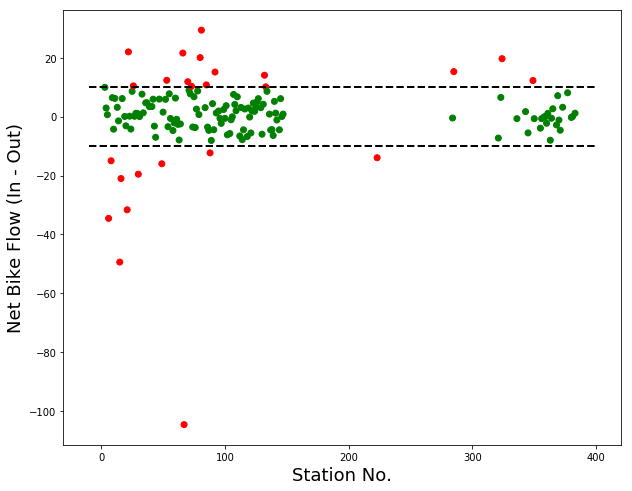

In [252]:
x = df.index
y = df['net'].values

plt.figure(figsize=(10,8))
plt.xlabel('Station No.', fontsize=18)
plt.ylabel('Net Bike Flow (In - Out)', fontsize=18)
plt.plot([-10, 400], [maxflow, maxflow], color='k', linestyle='--', linewidth=2)
plt.plot([-10, 400], [minflow, minflow], color='k', linestyle='--', linewidth=2)
col = np.where(x<0,'k',np.where(np.logical_or(y>maxflow,y<minflow),'r','g'))
plt.scatter(x,y, color=col);

In [233]:
df_source = df[df['net']>maxflow] #Create source dataframe, with all stations that have large in-traffic
df_source.head()

,bikes_out,bikes_in,net
22,138.556714,116.554689,22.002025
26,35.923481,25.469214,10.454267
53,31.359194,18.999961,12.359233
66,103.019203,81.414815,21.604388
70,32.257925,20.393348,11.864577


In [234]:
df_source.shape

(15, 3)

In [235]:
df_sink = df[df['net']<minflow] #Create sink dataframe, with all stations that have large out-traffic
df_sink.head()

,bikes_out,bikes_in,net
6,111.785342,146.316629,-34.531287
8,39.156881,54.135994,-14.979113
15,137.367035,186.742634,-49.375599
16,108.427759,129.438790,-21.011031
21,163.905258,195.530350,-31.625091


In [236]:
df_sink.shape

(10, 3)

In [237]:
#Get locations of all stations (for distance calculation)
path2 = "~/Documents/Berkeley MEng/Spring Semester/290/Project/datax_bikeshare/data/trip_summary_201901.csv"
locations = pd.read_csv(path2)
cols = ['start_station_id', 'start_station_latitude', 'start_station_longitude']
locations = locations[cols].drop_duplicates().set_index('start_station_id').sort_index()
locations.head()

,start_station_latitude,start_station_longitude
start_station_id,,
3,37.786375,-122.404904
4,37.785881,-122.408915
5,37.783899,-122.408445
6,37.804770,-122.403234
7,37.804562,-122.271738


In [238]:
#Function to calculate distance between two stations
def distance(station1id, station2id):
    a = locations.loc[station1id].values
    b = locations.loc[station2id].values
    return np.linalg.norm(a-b)

In [239]:
#Build a DataFrame of distances for all source-sink combinations
distances = pd.DataFrame(columns=['Source','Sink','Distance'])
for i in df_source.index:
    for j in df_sink.index:
        distances = distances.append({'Source': int(i), 'Sink': int(j), 'Distance': distance(i,j)}, ignore_index=True)
distances.head()

,Source,Sink,Distance
0,22.0,6.0,0.017298
1,22.0,8.0,0.010911
2,22.0,15.0,0.005653
3,22.0,16.0,0.004379
4,22.0,21.0,0.006169


In [240]:
distances = distances.pivot(index='Source',columns='Sink',values='Distance')
distances

Sink,6.0,8.0,15.0,16.0,21.0,30.0,49.0,67.0,88.0,223.0
Source,,,,,,,,,,
22.0,0.017298,0.010911,0.005653,0.004379,0.006169,0.013174,0.009003,0.013147,0.026095,0.035667
26.0,0.019594,0.013324,0.008104,0.006840,0.006842,0.010730,0.006558,0.010712,0.024470,0.034182
53.0,0.044990,0.046012,0.047717,0.047007,0.039416,0.042501,0.043058,0.042257,0.026715,0.020924
66.0,0.028064,0.021986,0.016714,0.015481,0.013549,0.003325,0.003022,0.003490,0.020888,0.030714
70.0,0.051725,0.052957,0.054741,0.054034,0.046442,0.049121,0.049863,0.048880,0.032732,0.025666
73.0,0.044901,0.045064,0.046017,0.045185,0.037419,0.038725,0.039743,0.038488,0.022053,0.015324
80.0,0.030099,0.024742,0.020415,0.019133,0.014781,0.002550,0.006043,0.002371,0.015207,0.024956
81.0,0.030593,0.024661,0.019539,0.018293,0.015726,0.002231,0.005208,0.002476,0.019456,0.029125
85.0,0.043303,0.042784,0.043154,0.042239,0.034429,0.034495,0.035796,0.034263,0.017430,0.010509


In [229]:
z = distances.values

Stuck here. Too many parameters to input manually. Maybe we can try AMPL with symbolic code and a data file.

In [3]:
C = np.array([
    [ 10, 7.5,   4],        #C1
    [  0,  10,   0],        #C2
    [0.5, 0.4, 0.5],        #C3
    [  0, 0.4,   0],        #C4
    [0.5, 0.1, 0.5],        #C5
    [0.4, 0.2, 0.4],        #C6
    [  1, 1.5, 0.5],        #C7
    [  1,   0,   0],        #C8
    [  0,   1,   0],        #C9
    [  0,   0,   1]         #C10
])

b = np.array([4350, 2500, 280, 140, 280, 140, 700, 300, 180, 400])

In [4]:
x1 = (0, None)
x2 = (0, None)
x3 = (0, None)

In [5]:
sol = linprog(-z, A_ub = C, b_ub = b, bounds = (x1, x2, x3), method='simplex')

#Profit Monthly
profit = (sol.fun*-1) - expense

sol

     fun: -168000.0
 message: 'Optimization terminated successfully.'
     nit: 2
   slack: array([400., 700.,  78.,  68., 132.,   0., 170.,  40.,   0., 400.])
  status: 0
 success: True
       x: array([260., 180.,   0.])

In [6]:
print(f"x1 = {sol.x[0]}, x2 = {sol.x[1]}, x3 = {sol.x[2]}, z = {profit}")

x1 = 260.0, x2 = 180.0, x3 = 0.0, z = 93000.0
